This notebook performs an oceanographic analysis focusing on salinity and temperature data from various CMIP6 climate models (`CESM2`, `MIROC6`, `IPSL-CM6A-LR`, `CAMS-CSM1-0`, `CNRM-ESM2-1`, `GFDL-ESM4`). The analysis includes:

1.  **Comparison with WOA Data**: Initial plots compare historical model outputs with the World Ocean Atlas (WOA) data for both salinity and temperature, displaying absolute values and isopycnal lines (`sigma_0`).

2.  **Anomaly Calculation**: The notebook calculates anomalies by subtracting historical mean conditions (1980-2014) from future projection scenarios (`SSP585` and `SSP370`) for the period 2080-2100 for both salinity and temperature.

3.  **Ensemble Mean and Statistical Significance**: For each scenario, individual model anomalies are plotted, followed by an ensemble mean. A t-test is performed on the ensemble mean to determine areas of statistical significance (p < 0.05), which are indicated by stippling on the ensemble mean plots.

4.  **Isopycnal Line Shifts**: Changes in isopycnal (density) lines between the historical mean and the future scenarios are also visualized on the anomaly plots to show shifts in water mass properties.

The figures generated are saved in the 'Figuras' and 'Figuras_Estatistica' directories.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

### Define the levels of the isopcanal lines.


In [ ]:
levels = {"CESM2": [26.6, 26.8, 27],
          "MIROC6": [26.8, 27, 27.2],
          "IPSL-CM6A-LR" :  [27, 27.2, 27.4],
          "CAMS-CSM1-0" : [26.6, 26.8, 27],
          "CNRM-ESM2-1" :  [27, 27.2, 27.4],
          "GFDL-ESM4" : [26.8, 27, 27.2],
         }

ensemble_levels = [26.8, 27, 27.2]

## Plot salinity

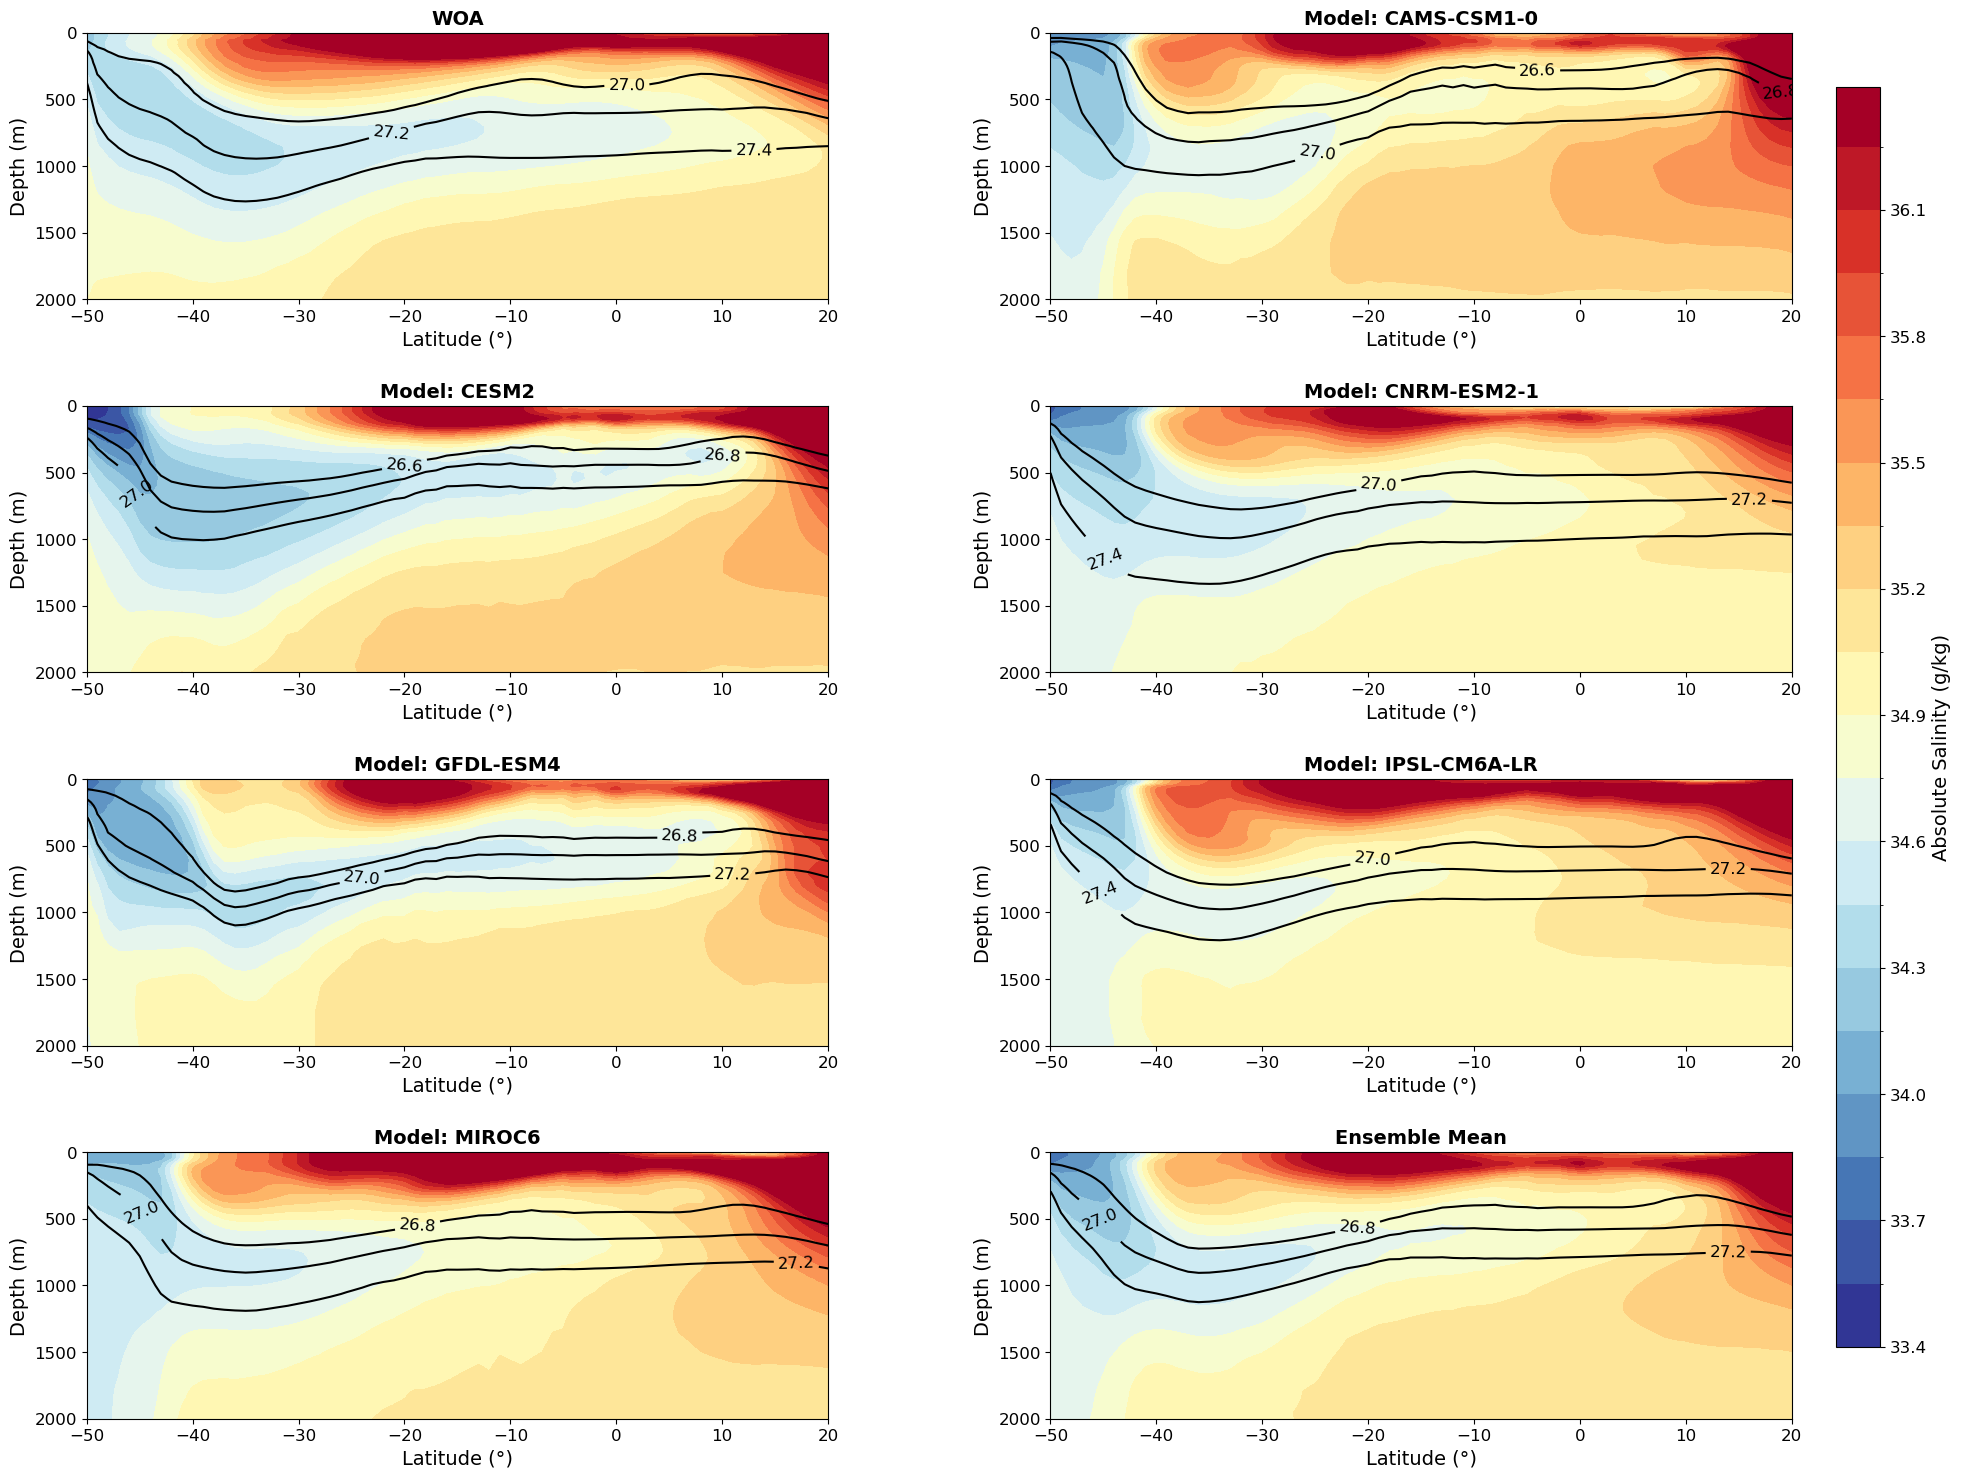

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import numpy as np
import glob
import os
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Dictionary of levels for density contours
levels = {"CESM2": [26.6, 26.8, 27],
          "MIROC6": [26.8, 27, 27.2],
          "IPSL-CM6A-LR" :  [27, 27.2, 27.4],
          "CAMS-CSM1-0" : [26.6, 26.8, 27],
          "CNRM-ESM2-1" :  [27, 27.2, 27.4],
          "GFDL-ESM4" : [26.8, 27, 27.2],
         }

# Gets the current directory where the notebook is located
# Adjustment: os.path.dirname(os.path.abspath('__file__')) might not work in all environments (like notebooks)
# Let's assume 'Arquivos' is a subdirectory of the current working directory.
pasta_atual = os.path.join(os.getcwd(), 'Arquivos') # MODIFIED: Using os.getcwd() for more robustness

# Uses the glob library to get all NetCDF files in the folder
arquivos = glob.glob(os.path.join(pasta_atual, '*.nc'))

# Filters files to include only those with "historical" in the name
arquivos = [arquivo for arquivo in arquivos if "historical" in arquivo]

# Sorts files based on model name
arquivos = sorted(arquivos, key=lambda x: os.path.basename(x).split(".")[2])

i, j = 0, 0

# Checks if there are files to process
if not arquivos:
    print("No 'historical' files found in the folder.")
else:
    # Opens the WOA dataset
    # Ensure 'woa_1981_2010.nc' is in the correct directory
    try:
        woa_ds = xr.open_dataset(r"woa_1981_2010.nc", decode_times=False).isel(time=0).mean(dim='lon')
    except FileNotFoundError:
        print("File 'woa_1981_2010.nc' not found. Check the path.")
        exit() # Exits if the base file is not found

    # Initializes a figure with subplots (2 rows, 4 columns)
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(22, 18))

    # Plots WOA in the corresponding subplot
    c_levels = np.arange(33.4, 36.4, 0.15)

    ax = axs[0,0]
    contour_woa = woa_ds.sa.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="RdYlBu_r", vmin=33.4,
                                          vmax=36.4, add_colorbar=False)
    contour_lines_woa = woa_ds.sigma_0.plot.contour(ax=axs[0, 0], levels=[27, 27.2, 27.4], colors='k')
    ax.clabel(contour_lines_woa, inline=True, fontsize=12, fmt='%1.1f')
    ax.set_ylim(0, 2000)
    ax.set_xlim(-50, 20)
    ax.invert_yaxis()
    ax.set_title("WOA")
    ax.set_xlabel("Latitude (°)")
    ax.set_ylabel("Depth (m)")

    #Subplots for the files
    j = j + 1

    # NEW: List to store data for each model for the ensemble mean
    all_models_zonal = []

    # Loop through files
    for arquivo in arquivos:
        # Opens the dataset
        ds = xr.open_dataset(arquivo)

        # Gets model name from file name
        modelo = os.path.basename(arquivo).split(".")[2]

        # Calculates zonal mean
        zonal = ds.sel(time=slice("1981", "2010")).mean(dim="time")
        zonal["sigma0"] = gsw.sigma0(zonal["sa"], zonal["thetao"])

        # NEW: Adds zonal result to list
        all_models_zonal.append(zonal)

        # Defines plot levels
        c_levels = np.arange(33.4, 36.4, 0.15)

        # Calculates subplot column
        ax = axs[i, j]
        # 'contour' will be overwritten, the last one (ensemble mean) will be used for the colorbar
        contour = zonal.so.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="RdYlBu_r", vmin=33.4,
                                          vmax=36.4, add_colorbar=False)
        # Apply mask for sigma0 > 26.4 (optional, removed as it wasn't in the original code for `contour`)
        # masked_sigma0 = zonal.sigma0.where(zonal.sigma0 > 26.4)

        # Plot contour for sigma0
        contour_lines = zonal.sigma0.plot.contour(ax=ax, levels=levels[modelo], colors='k')
        ax.clabel(contour_lines, inline=True, fontsize=12, fmt='%1.1f')
        ax.set_ylim(0, 2000)
        ax.set_xlim(-50, 20)
        ax.invert_yaxis()
        ax.set_title(f"Model: {modelo}")
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

        #Changes subplot columns and rows
        j += 1

        if j > 1:
            j = 0
            i += 1

        # Closes the dataset
        ds.close()

    # NEW: Calculate and plot the Ensemble Mean
    if all_models_zonal: # Checks if the list is not empty
        # Concatenates all DataArrays along a new "model" dimension and calculates the mean
        ensemble_mean = xr.concat(all_models_zonal, dim="model").mean(dim="model")

        # Defines levels for the ensemble mean (can be the average of others or a fixed value)
        ensemble_levels = [26.8, 27, 27.2] # Choose a representative set

        # Uses the last available axis (axs[i, j])
        ax = axs[i, j]
        contour = ensemble_mean.so.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="RdYlBu_r", vmin=33.4,
                                                  vmax=36.4, add_colorbar=False)
        contour_lines_ensemble = ensemble_mean.sigma0.plot.contour(ax=ax, levels=ensemble_levels, colors='k')
        ax.clabel(contour_lines_ensemble, inline=True, fontsize=12, fmt='%1.1f')
        ax.set_ylim(0, 2000)
        ax.set_xlim(-50, 20)
        ax.invert_yaxis()
        ax.set_title("Ensemble Mean")
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')


    # Adds a single colorbar for the entire figure
    # MODIFIED: Adjust colorbar position to accommodate the 4x2 grid
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # Position: [left, bottom, width, height]
    cbar = plt.colorbar(contour, cax=cbar_ax, orientation='vertical', extendrect=True) # shrink removed
    cbar.set_ticks(np.arange(33.4, 36.4, 0.3))
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Absolute Salinity (g/kg)', size=14)

    # Defines title size, axes, etc.
    for ax in axs.flat:
        # Avoids formatting axes that might not exist if there's an error
        if not ax.has_data():
            continue
        ax.title.set_fontsize(14)
        ax.title.set_weight('bold')
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

    # MODIFIED: Removes the line that deleted the last subplot
    # This line was removed

    #Spacing between rows and columns
    plt.subplots_adjust(hspace=0.4, wspace=0.3) # Added wspace for horizontal spacing

    # Ensures the 'Figuras' directory exists
    os.makedirs('Figuras', exist_ok=True)

    # Saves the figure
    plt.savefig('Figuras/Salinidade_Modelos_com_WOA_e_Ensemble.png', bbox_inches='tight', dpi=600)

    # Shows the figure (optional)
    plt.show()

    # Closes the WOA dataset
    woa_ds.close()

## Plot temperature

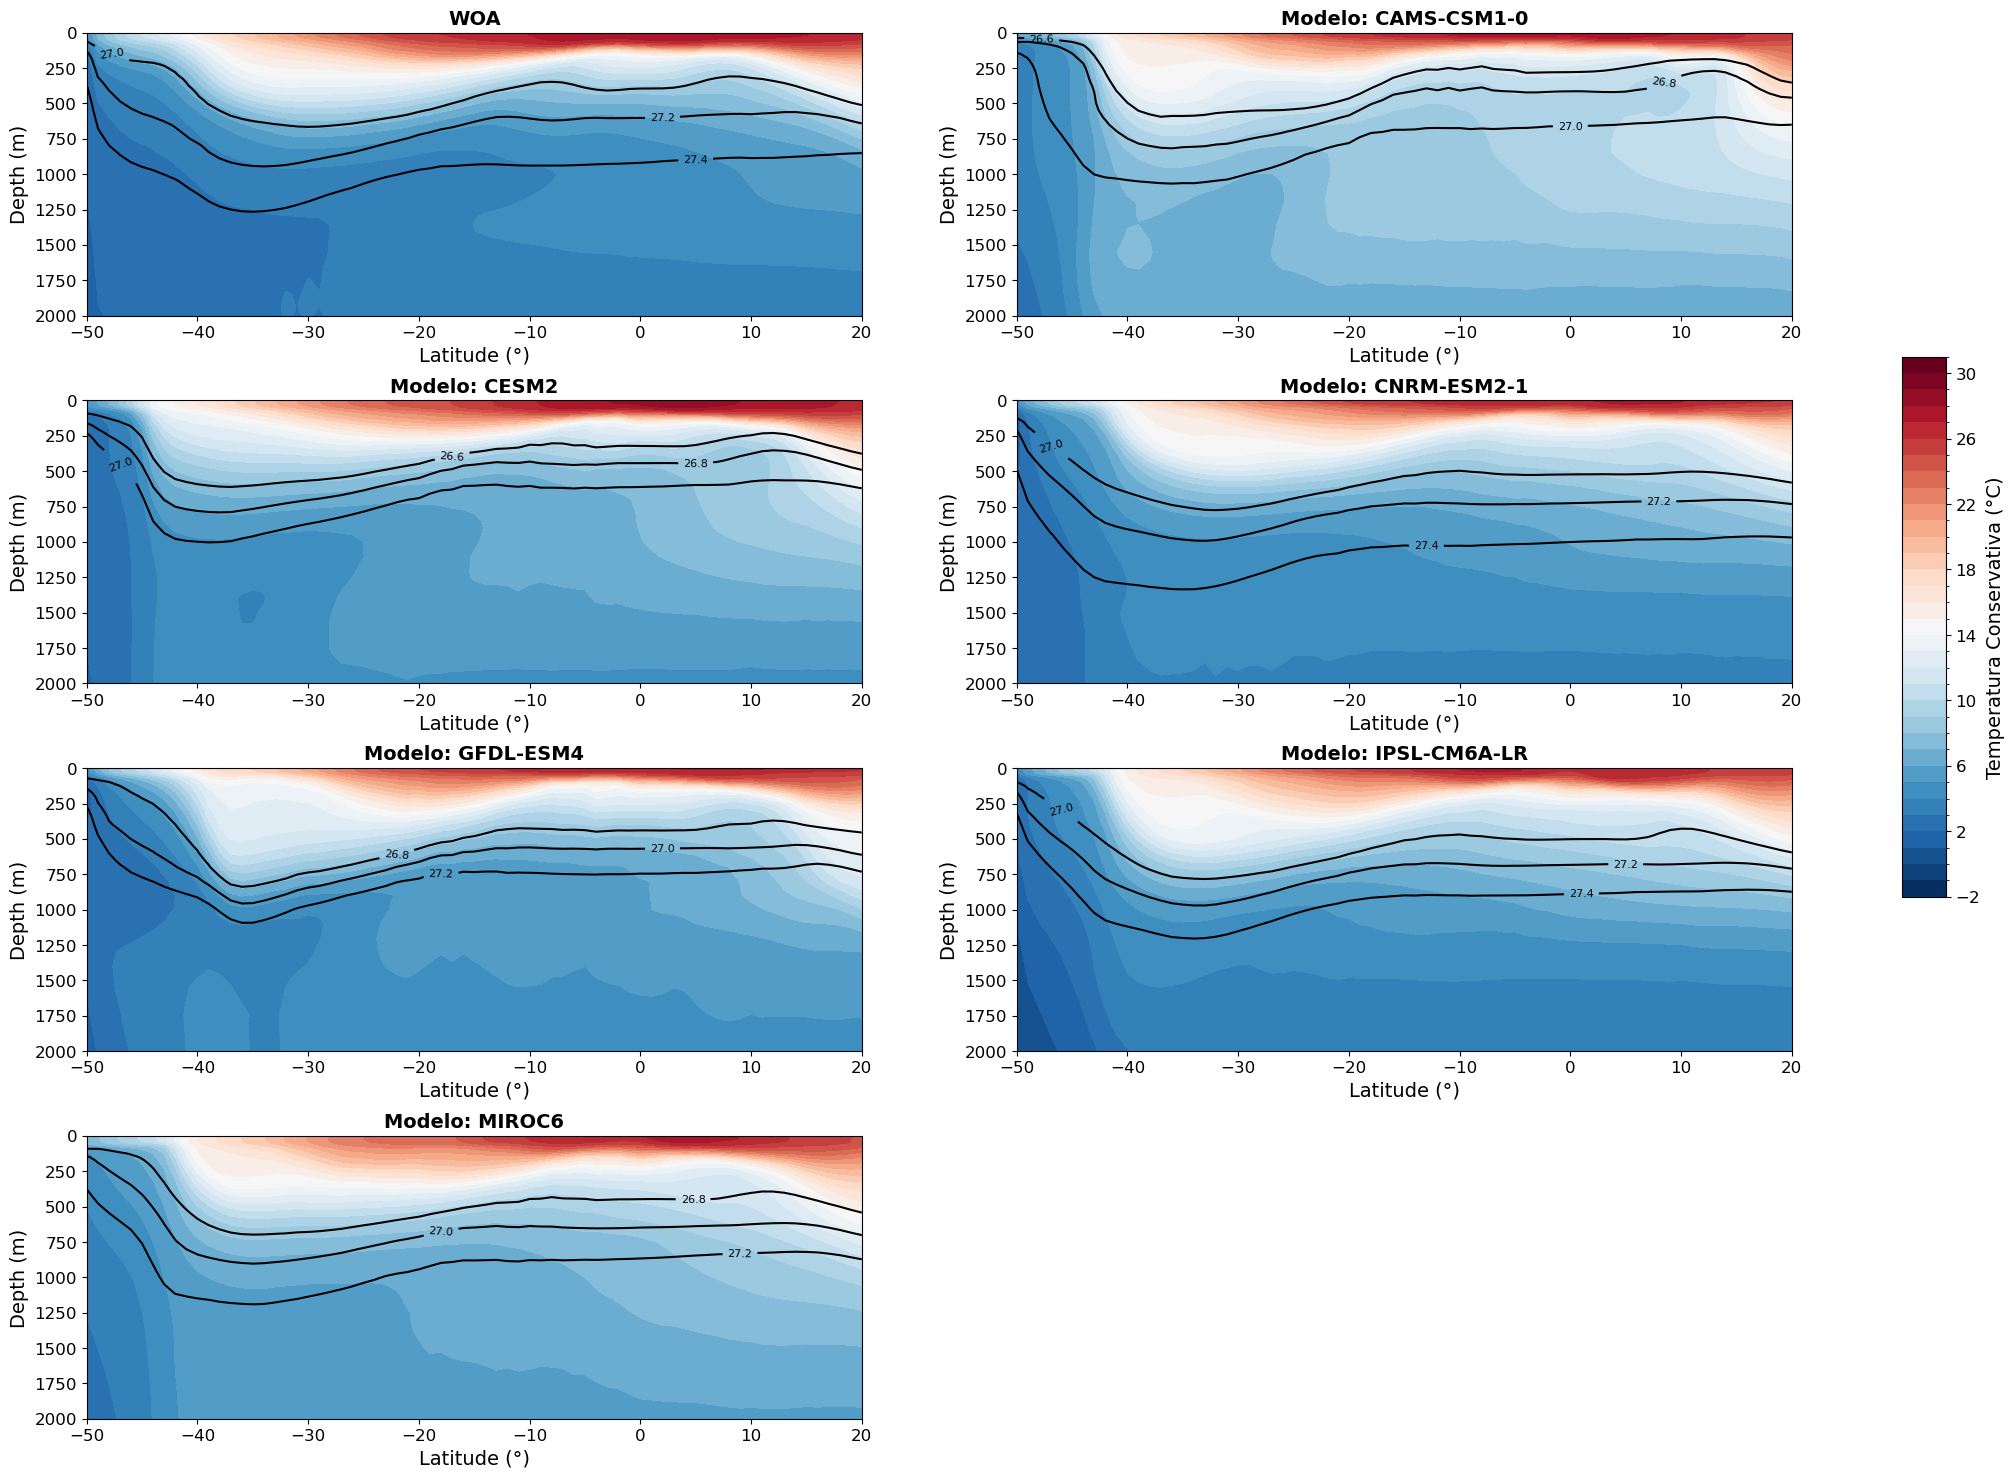

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import gsw  # Make sure you have this library installed

# Gets the current directory where the notebook is located
pasta_atual = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'Arquivos')

# Uses the glob library to get all NetCDF files in the folder
arquivos = glob.glob(os.path.join(pasta_atual, '*.nc'))

# Filters files to include only those with "historical" in the name
arquivos = [arquivo for arquivo in arquivos if "historical" in arquivo]

# Sorts files based on model name
arquivos = sorted(arquivos, key=lambda x: os.path.basename(x).split(".")[2])

#Levels for plot
c_levels = np.arange(-2, 32, 1)

i, j = 0, 0

# Checks if there are files to process
if not arquivos:
    print("No 'historical' files found in the folder.")
else:
    # Opens the WOA dataset
    woa_ds = xr.open_dataset(r"woa_1981_2010.nc", decode_times=False).isel(time=0).mean(dim='lon')  # Replace with the actual path to your WOA file

    # Initializes a figure with subplots (2 rows, 4 columns)
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(22, 18))

    #Defines the axes
    ax = axs[0, 0]
    # Plots WOA in the corresponding subplot
    contour_woa = woa_ds.c_t.plot.contourf(ax=ax, x="lat", levels=c_levels,
                                            cmap="RdBu_r", vmin=-2, vmax=32, add_colorbar=False)
    contour_lines_woa = woa_ds.sigma_0.plot.contour(ax=axs[0, 0], levels=[27, 27.2, 27.4], colors='k')
    ax.clabel(contour_lines_woa, inline=True, fontsize=8, fmt='%1.1f')
    ax.set_ylim(0, 2000)
    ax.invert_yaxis()
    ax.set_title("WOA")
    ax.set_xlabel("Latitude (°)")
    ax.set_ylabel("Depth (m)")

    j = j + 1

    # Loop through files
    for arquivo in arquivos:
        # Opens the dataset
        ds = xr.open_dataset(arquivo)

        # Gets model name from file name
        modelo = os.path.basename(arquivo).split(".")[2]  # Adjust this according to your file naming structure

        # Calculates zonal mean
        zonal = ds.sel(time=slice("1955", "2014")).mean(dim="time")
        zonal["sigma0"] = gsw.sigma0(zonal["sa"], zonal["thetao"])

        ax = axs[i, j]

        # Plots in the corresponding subplot
        contour = zonal.thetao.plot.contourf(ax=axs[i, j], x="lat", levels=c_levels, cmap="RdBu_r",
                                             vmin=-2, vmax=32, add_colorbar=False)
        # Plot contour for sigma0 after applying the mask
        contour_lines = zonal.sigma0.plot.contour(ax=ax, levels=levels[modelo], colors='k')
        ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        ax.set_title(f"Model: {modelo}")
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

        j += 1

        if j > 1:
            j = 0
            i += 1
        # Closes the dataset
        ds.close()

    # Adds colorbar manually
    cbar_ax = fig.add_axes([0.95, 0.4, 0.02, 0.3])
    cbar = plt.colorbar(contour, cax=cbar_ax, orientation='vertical', extendrect=True, shrink=0.1)
    cbar.set_ticks(np.arange(-2, 32, 4))  # Adjust ticks as needed
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Conservative Temperature (°C)', size=14)

    # Defines title size, axes, etc.
    for ax in axs.flat:
        ax.title.set_fontsize(14)
        ax.title.set_weight('bold')
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

    # Removes the last subplot as it is empty
    fig.delaxes(axs[i, j])

    #Spacing between rows
    plt.subplots_adjust(hspace=0.3)

    # Saves the figure
    #plt.savefig('Figuras2/Temperatura_Modelos_com_WOA.png', bbox_inches='tight')

    # Shows the figure (optional)
    plt.show()

    # Closes the WOA dataset
    woa_ds.close()

## Plots differences scenarios


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Definir os valores e criar uma matriz de exemplo
dados = np.random.uniform(-0.2, 0.8, (10, 10))

# Configurar o colormap com bwr e a normalização de cores
cmap = 'bwr'
norm = TwoSlopeNorm(vmin=-0.2, vcenter=0, vmax=0.8)

### SSP585 Salinity

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import numpy as np
import glob
import os
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import scipy.stats as stats # <--- ADD THIS LINE

C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dty

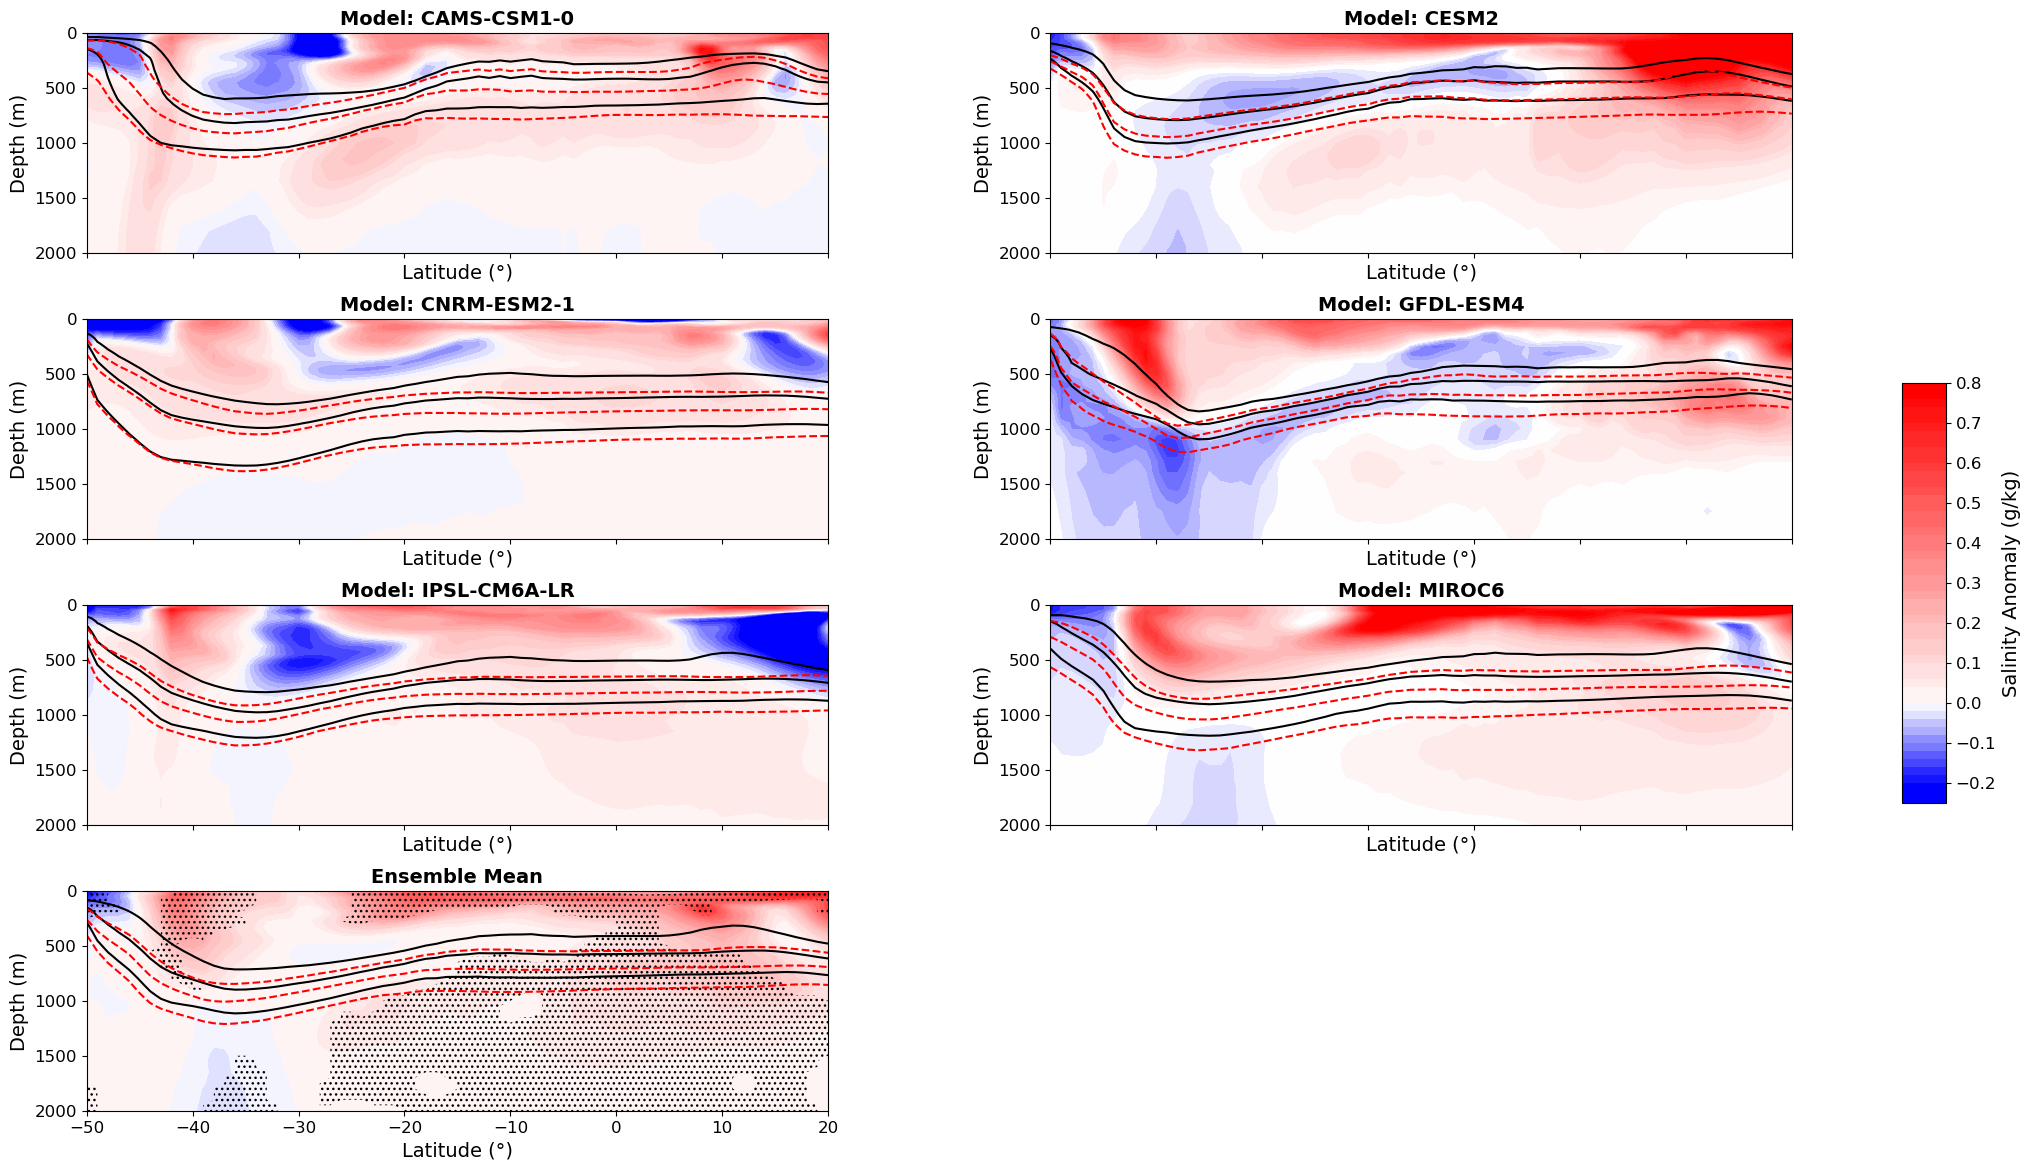

In [ ]:
import os
import glob
import xarray as xr
import gsw
import matplotlib.pyplot as plt
import numpy as np # Added
import matplotlib.colors # Added

# Gets the current directory where the notebook is located
# Adjustment: Use a relative path or define 'pasta_atual' directly
pasta_atual = 'Arquivos' # Simplified

# Uses the glob library to get all NetCDF files in the folder
arquivos = glob.glob(os.path.join(pasta_atual, '*.nc'))

# Sorts files based on model name
arquivos = sorted(arquivos, key=lambda x: os.path.basename(x).split(".")[2])

# Dictionary to store historical data
historical_data = {}

# Levels for anomaly plot (filled)
c_levels = np.arange(-0.2, 0.801, 0.02)

### CHANGE 1: Use TwoSlopeNorm to center white at 0 ###
# Defines normalization for the colorbar, centering white at 0
norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-0.2, vmax=0.8)
### END OF CHANGE 1 ###


# !!! NOTE: Your variable 'levels[model]' was not defined.
# I used this placeholder list for ALL contour lines (sigma).
# Adjust this list as needed.
sigma_levels_to_plot = [26.5, 27.0, 27.2]


# Loop through files for historical data
for arquivo in arquivos:
    if "historical" in arquivo:
        ds = xr.open_dataset(arquivo)
        modelo = os.path.basename(arquivo).split(".")[2]
        historical_data[modelo] = ds.sel(time=slice("1980", "2014")).mean(dim="time")
        ds.close()

# Initializes a figure with subplots (3 rows, 2 columns)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(22, 14), sharex=True)

i, j = 0, 0

# Lists to store datasets for the ensemble
diff_datasets = []
historical_datasets_for_ensemble = []
ssp_datasets_for_ensemble = []

# Loop again to process ssp585 files
for arquivo in arquivos:
    if "ssp585" in arquivo:
        ds = xr.open_dataset(arquivo)
        modelo = os.path.basename(arquivo).split(".")[2]

        # Checks for corresponding historical data
        if modelo not in historical_data:
            print(f"Warning: Historical data not found for {modelo}. Skipping.")
            ds.close()
            continue

        ssp585_data = ds.sel(time=slice("2080", "2100")).mean(dim="time")
        historical = historical_data[modelo]

        # Calculates sigma0
        historical["sigma0"] = gsw.sigma0(historical["sa"], historical["thetao"])
        ssp585_data["sigma0"] = gsw.sigma0(ssp585_data["sa"], ssp585_data["thetao"])

        # Calculates the difference
        diff = ssp585_data - historical

        # Adds datasets to lists for ensemble calculation
        diff_datasets.append(diff)
        historical_datasets_for_ensemble.append(historical)
        ssp_datasets_for_ensemble.append(ssp585_data)

        # --- Individual Model Plotting ---
        ax = axs[i, j]

        # Plot of anomaly (diff.so)
        # Note that 'norm=norm' now uses the TwoSlopeNorm defined above
        contour = diff.so.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                          vmin=-0.2, vmax=0.8, norm=norm)

        # Apply mask for sigma0
        masked1_sigma0 = historical.sigma0.where(historical.sigma0 > 26.2)
        masked2_sigma0 = ssp585_data.sigma0.where(ssp585_data.sigma0 > 26.2)

        # Plot of contour lines (using xarray's .plot.contour)
        masked1_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                      colors='black', linestyles="solid")

        masked2_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                      colors='red', linestyles="dashed")

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        # Title in English
        ax.set_title(f"Model: {modelo}")

        # Labels in English
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

        ds.close()

        # Increments axes
        j += 1
        if j > 1:
            j = 0
            i += 1

        # Stops the loop if 'i' exceeds the number of rows
        if i >= axs.shape[0]:
            print("Warning: More models than available axes. Stopping plotting loop.")
            break

# --- Ensemble Mean Calculation and Plot ---
if diff_datasets:
    # Checks if the list is not empty
    if i < axs.shape[0]:
        # Gets the last available axis (should be axs[i, j])
        ax = axs[i, j]

        # --- Calculate Ensemble Means ---

        # Concatenates all anomaly datasets into a single xarray
        all_models_diff = xr.concat(diff_datasets, dim="model", coords="minimal", compat='override')

        # 1. Anomaly Mean (Diff)
        ensemble_mean_diff = all_models_diff.mean(dim="model")

        # 2. Historical Mean (for contour lines)
        ensemble_hist = xr.concat(historical_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_hist["sigma0"] = gsw.sigma0(ensemble_hist["sa"], ensemble_hist["thetao"])

        # 3. SSP Mean (for contour lines)
        ensemble_ssp = xr.concat(ssp_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_ssp["sigma0"] = gsw.sigma0(ensemble_ssp["sa"], ensemble_ssp["thetao"])


        # --- STATISTICAL SIGNIFICANCE CALCULATION (T-TEST) ---
        n_models = len(diff_datasets)
        significance_mask = None

        if n_models > 1: # t-test requires at least 2 samples
            # Calculates standard deviation across the 'model' dimension
            ensemble_std = all_models_diff.std(dim="model")

            # Calculates t-statistic: t = (mean - 0) / (std / sqrt(n))
            # t_stat is still an xarray.DataArray
            with np.errstate(divide='ignore', invalid='ignore'):
                t_stat = (ensemble_mean_diff.so / (ensemble_std.so / np.sqrt(n_models))).fillna(0)

            # Degrees of freedom = n - 1
            df = n_models - 1

            # --- CORRECTION APPLIED HERE ---
            # 1. Calculate p-values using .values to get a numpy array
            p_values_np = stats.t.sf(np.abs(t_stat.values), df=df) * 2

            # 2. Convert p_values back to xarray.DataArray,
            #    copying coords and dims from t_stat
            p_values_da = xr.DataArray(p_values_np, coords=t_stat.coords, dims=t_stat.dims)

            # 3. Create the mask using the DataArray.
            #    Now, significance_mask will also be an xarray.DataArray
            significance_mask = xr.where(p_values_da < 0.05, 1, np.nan)
            # --- END OF CORRECTION ---

        # --- END OF SIGNIFICANCE CALCULATION ---

        # --- Plot Ensemble Mean Diff ---
        contour = ensemble_mean_diff.so.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                                      vmin=-0.2, vmax=0.8, norm=norm)


        # --- PLOT STIPPLING ---
        if significance_mask is not None:
            # We use contourf with 'hatches' to create stippling
            # We plot only where the mask is 1
            significance_mask.plot.contourf(
                ax=ax,
                levels=[0.5, 1.5],     # Levels to pick '1' values
                colors='none',         # We don't want color filling
                hatches=['...'],       # Defines the stippling pattern
                add_colorbar=False
            )
        # --- END OF STIPPLING ---


        # --- Plot Ensemble Sigma Lines ---
        ensemble_hist.sigma0.where(ensemble_hist.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='black', linestyles="solid")

        ensemble_ssp.sigma0.where(ensemble_ssp.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='red', linestyles="dashed")

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        # Title in English
        ax.set_title("Ensemble Mean")
        # Labels in English
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

# --- Finalization and Colorbar ---

### CHANGE 2: Turn off (delete) remaining unused axes ###
# Calculates the "flat" index of the axis we just used for the ensemble
current_flat_index = i * axs.shape[1] + j
# Iterates and turns off all axes *after* the ensemble
for k in range(current_flat_index + 1, len(axs.flat)):
    axs.flat[k].axis('off')
### END OF CHANGE 2 ###


# Adds the colorbar
cbar_ax = fig.add_axes([0.95, 0.33, 0.02, 0.3])
cbar = plt.colorbar(contour, cax=cbar_ax, orientation='vertical', extendrect=True, shrink=0.1)
cbar.set_ticks(np.arange(-0.2, 0.802, 0.1))
# Colorbar Label in English
cbar.set_label('Salinity Anomaly (g/kg)', size=14)
cbar.ax.tick_params(labelsize=12)

# Defines title size, axes, etc.
for k in range(current_flat_index + 1): # Iterates only over the plotted axes
    ax = axs.flat[k]
    ax.title.set_fontsize(14)
    ax.title.set_weight('bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Spacing between rows
plt.subplots_adjust(hspace=0.3, wspace=0.3) # wspace added

# Create 'Figuras' folder if it doesn't exist
os.makedirs('Figuras', exist_ok=True)

# Saves the figure (File name in English)
plt.savefig("Figuras_Estatistica/SSP585_Salinity_Anomalies_Models_Ensemble.png", bbox_inches='tight', dpi=600)

# Displays the figure
plt.show()

### SSP370 Salinity

C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dty

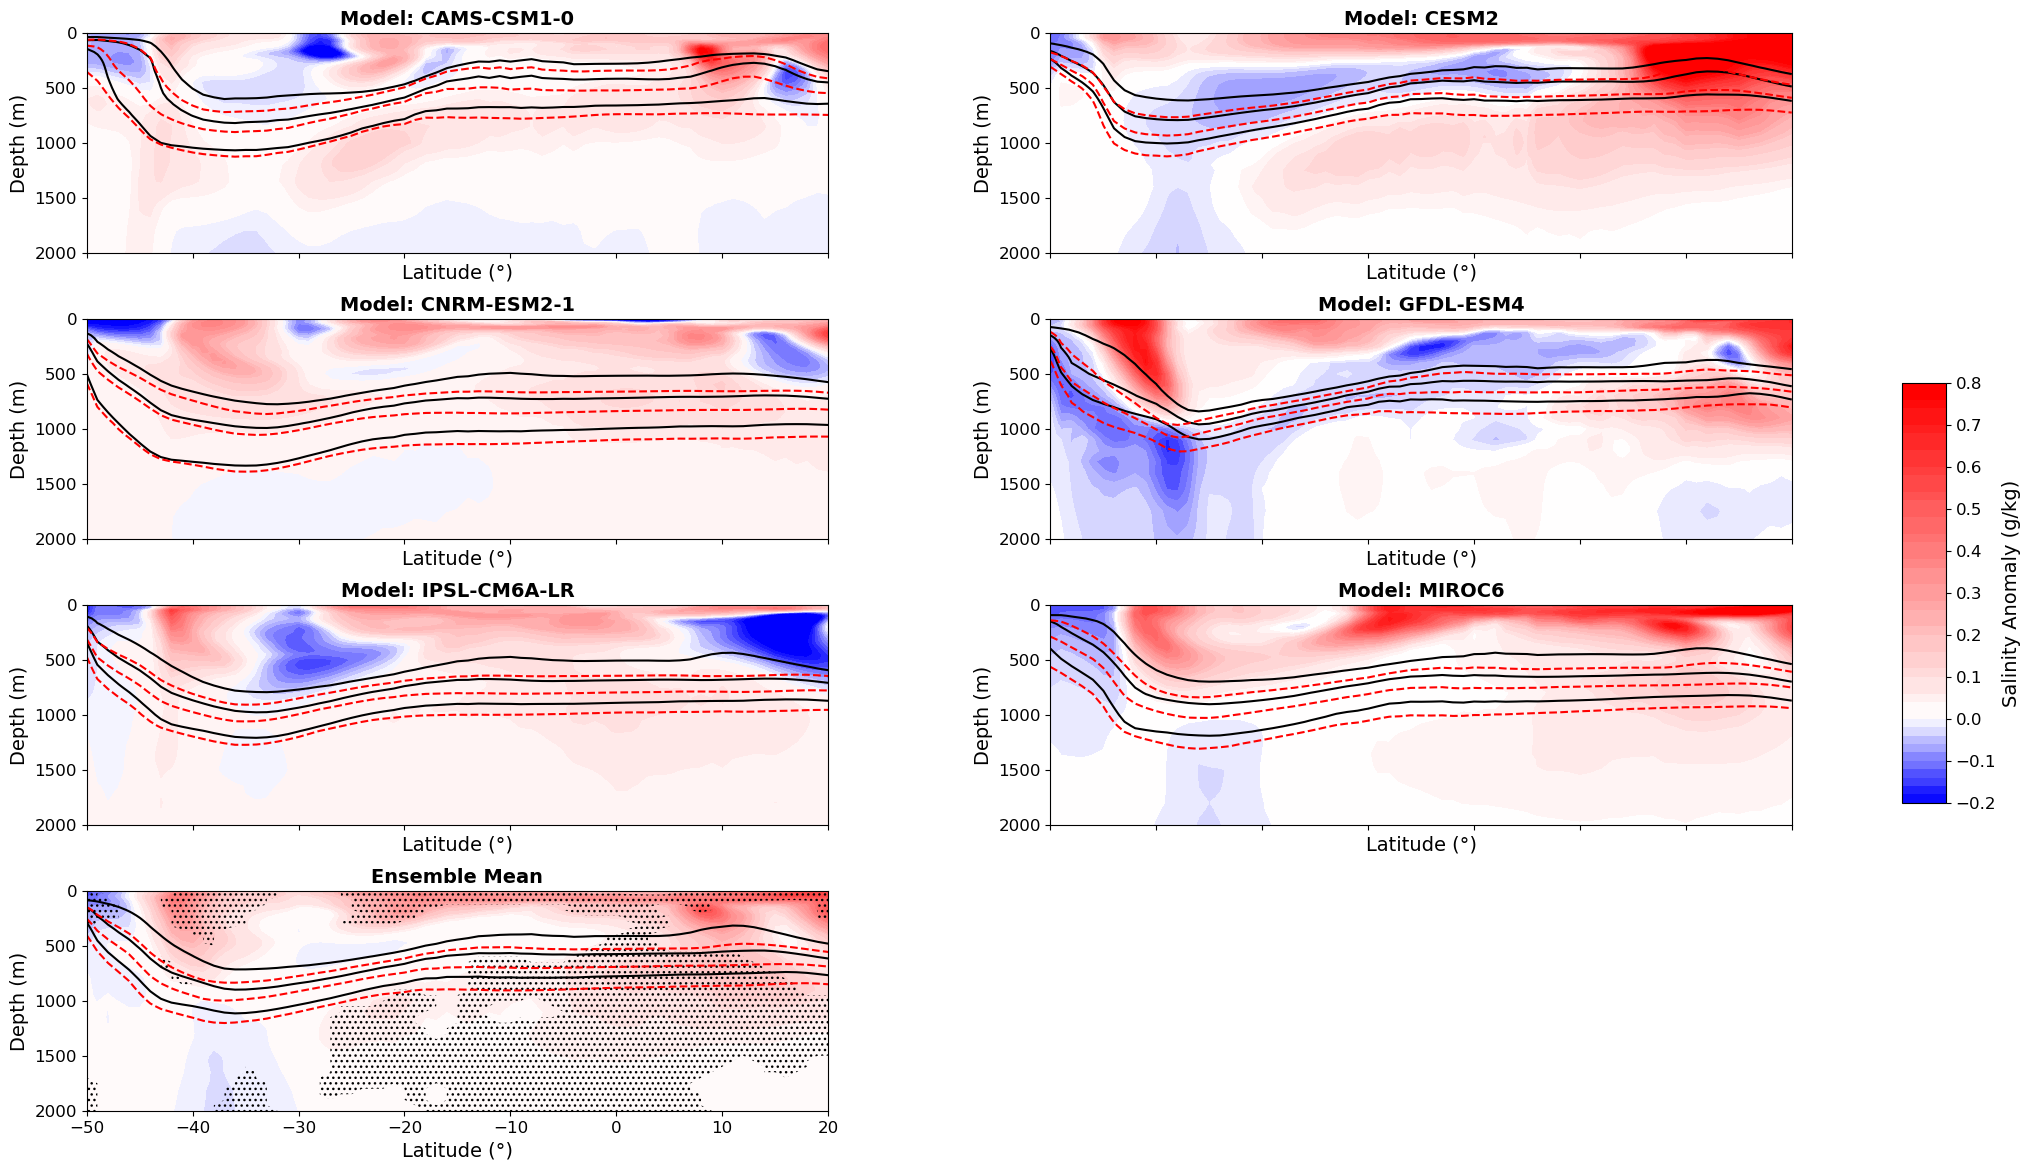

In [ ]:
import os
import glob
import xarray as xr
import gsw
import matplotlib.pyplot as plt
import numpy as np # Added
import matplotlib.colors # Added

# Gets the current directory where the notebook is located
# Adjustment: Use a relative path or define 'pasta_atual' directly
pasta_atual = 'Arquivos' # Simplified

# Uses the glob library to get all NetCDF files in the folder
arquivos = glob.glob(os.path.join(pasta_atual, '*.nc'))

# Sorts files based on model name
arquivos = sorted(arquivos, key=lambda x: os.path.basename(x).split(".")[2])

# Dictionary to store historical data
historical_data = {}

# Levels for anomaly plot (filled)
c_levels = np.arange(-0.2, 0.801, 0.02)

### CHANGE 1: Use TwoSlopeNorm to center white at 0 ###
# Defines normalization for the colorbar, centering white at 0
norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-0.2, vmax=0.8)
### END OF CHANGE 1 ###


# !!! NOTE: Your variable 'levels[model]' was not defined.
# I used this placeholder list for ALL contour lines (sigma).
# Adjust this list as needed.
sigma_levels_to_plot = [26.5, 27.0, 27.2]


# Loop through files for historical data
for arquivo in arquivos:
    if "historical" in arquivo:
        ds = xr.open_dataset(arquivo)
        modelo = os.path.basename(arquivo).split(".")[2]
        historical_data[modelo] = ds.sel(time=slice("1980", "2014")).mean(dim="time")
        ds.close()

# Initializes a figure with subplots (3 rows, 2 columns)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(22, 14), sharex=True)

i, j = 0, 0

# Lists to store datasets for the ensemble
diff_datasets = []
historical_datasets_for_ensemble = []
ssp_datasets_for_ensemble = []

# Loop again to process ssp585 files
for arquivo in arquivos:
    if "ssp370" in arquivo:
        ds = xr.open_dataset(arquivo)
        modelo = os.path.basename(arquivo).split(".")[2]

        # Checks for corresponding historical data
        if modelo not in historical_data:
            print(f"Warning: Historical data not found for {modelo}. Skipping.")
            ds.close()
            continue

        ssp585_data = ds.sel(time=slice("2080", "2100")).mean(dim="time")
        historical = historical_data[modelo]

        # Calculates sigma0
        historical["sigma0"] = gsw.sigma0(historical["sa"], historical["thetao"])
        ssp585_data["sigma0"] = gsw.sigma0(ssp585_data["sa"], ssp585_data["thetao"])

        # Calculates the difference
        diff = ssp585_data - historical

        # Adds datasets to lists for ensemble calculation
        diff_datasets.append(diff)
        historical_datasets_for_ensemble.append(historical)
        ssp_datasets_for_ensemble.append(ssp585_data)

        # --- Individual Model Plotting ---
        ax = axs[i, j]

        # Plot of anomaly (diff.so)
        # Note that 'norm=norm' now uses the TwoSlopeNorm defined above
        contour = diff.so.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                          vmin=-0.2, vmax=0.8, norm=norm)

        # Apply mask for sigma0
        masked1_sigma0 = historical.sigma0.where(historical.sigma0 > 26.2)
        masked2_sigma0 = ssp585_data.sigma0.where(ssp585_data.sigma0 > 26.2)

        # Plot of contour lines (using xarray's .plot.contour)
        masked1_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                      colors='black', linestyles="solid")

        masked2_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                      colors='red', linestyles="dashed")

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        # Title in English
        ax.set_title(f"Model: {modelo}")

        # Labels in English
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

        ds.close()

        # Increments axes
        j += 1
        if j > 1:
            j = 0
            i += 1

        # Stops the loop if 'i' exceeds the number of rows
        if i >= axs.shape[0]:
            print("Warning: More models than available axes. Stopping plotting loop.")
            break

# --- Ensemble Mean Calculation and Plot ---
if diff_datasets:
    # Checks if the list is not empty
    if i < axs.shape[0]:
        # Gets the last available axis (should be axs[i, j])
        ax = axs[i, j]

        # --- Calculate Ensemble Means ---

        # Concatenates all anomaly datasets into a single xarray
        all_models_diff = xr.concat(diff_datasets, dim="model", coords="minimal", compat='override')

        # 1. Anomaly Mean (Diff)
        ensemble_mean_diff = all_models_diff.mean(dim="model")

        # 2. Historical Mean (for contour lines)
        ensemble_hist = xr.concat(historical_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_hist["sigma0"] = gsw.sigma0(ensemble_hist["sa"], ensemble_hist["thetao"])

        # 3. SSP Mean (for contour lines)
        ensemble_ssp = xr.concat(ssp_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_ssp["sigma0"] = gsw.sigma0(ensemble_ssp["sa"], ensemble_ssp["thetao"])


        # --- STATISTICAL SIGNIFICANCE CALCULATION (T-TEST) ---
        n_models = len(diff_datasets)
        significance_mask = None

        if n_models > 1: # t-test requires at least 2 samples
            # Calculates standard deviation across the 'model' dimension
            ensemble_std = all_models_diff.std(dim="model")

            # Calculates t-statistic: t = (mean - 0) / (std / sqrt(n))
            # t_stat is still an xarray.DataArray
            with np.errstate(divide='ignore', invalid='ignore'):
                t_stat = (ensemble_mean_diff.so / (ensemble_std.so / np.sqrt(n_models))).fillna(0)

            # Degrees of freedom = n - 1
            df = n_models - 1

            # --- CORRECTION APPLIED HERE ---
            # 1. Calculate p-values using .values to get a numpy array
            p_values_np = stats.t.sf(np.abs(t_stat.values), df=df) * 2

            # 2. Convert p_values back to xarray.DataArray,
            #    copying coords and dims from t_stat
            p_values_da = xr.DataArray(p_values_np, coords=t_stat.coords, dims=t_stat.dims)

            # 3. Create the mask using the DataArray.
            #    Now, significance_mask will also be an xarray.DataArray
            significance_mask = xr.where(p_values_da < 0.05, 1, np.nan)
            # --- END OF CORRECTION ---

        # --- END OF SIGNIFICANCE CALCULATION ---

        # --- Plot Ensemble Mean Diff ---
        contour = ensemble_mean_diff.so.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                                      vmin=-0.2, vmax=0.8, norm=norm)


        # --- PLOT STIPPLING ---
        if significance_mask is not None:
            # We use contourf with 'hatches' to create stippling
            # We plot only where the mask is 1
            significance_mask.plot.contourf(
                ax=ax,
                levels=[0.5, 1.5],     # Levels to pick '1' values
                colors='none',         # We don't want color filling
                hatches=['...'],       # Defines the stippling pattern
                add_colorbar=False
            )
        # --- END OF STIPPLING ---


        # --- Plot Ensemble Sigma Lines ---
        ensemble_hist.sigma0.where(ensemble_hist.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='black', linestyles="solid")

        ensemble_ssp.sigma0.where(ensemble_ssp.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='red', linestyles="dashed")

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        # Title in English
        ax.set_title("Ensemble Mean")
        # Labels in English
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

# --- Finalization and Colorbar ---

### CHANGE 2: Turn off (delete) remaining unused axes ###
# Calculates the "flat" index of the axis we just used for the ensemble
current_flat_index = i * axs.shape[1] + j
# Iterates and turns off all axes *after* the ensemble
for k in range(current_flat_index + 1, len(axs.flat)):
    axs.flat[k].axis('off')
### END OF CHANGE 2 ###


# Adds the colorbar
cbar_ax = fig.add_axes([0.95, 0.33, 0.02, 0.3])
cbar = plt.colorbar(contour, cax=cbar_ax, orientation='vertical', extendrect=True, shrink=0.1)
cbar.set_ticks(np.arange(-0.2, 0.802, 0.1))
# Colorbar Label in English
cbar.set_label('Salinity Anomaly (g/kg)', size=14)
cbar.ax.tick_params(labelsize=12)

# Defines title size, axes, etc.
for k in range(current_flat_index + 1): # Iterates only over the plotted axes
    ax = axs.flat[k]
    ax.title.set_fontsize(14)
    ax.title.set_weight('bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Spacing between rows
plt.subplots_adjust(hspace=0.3, wspace=0.3) # wspace added

# Create 'Figuras' folder if it doesn't exist
os.makedirs('Figuras', exist_ok=True)

# Saves the figure (File name in English)
plt.savefig("Figuras_Estatistica/SSP370_Salinity_Anomalies_Models_Ensemble.png", bbox_inches='tight', dpi=600)

# Displays the figure
plt.show()

### Temperature ssp585

C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dty

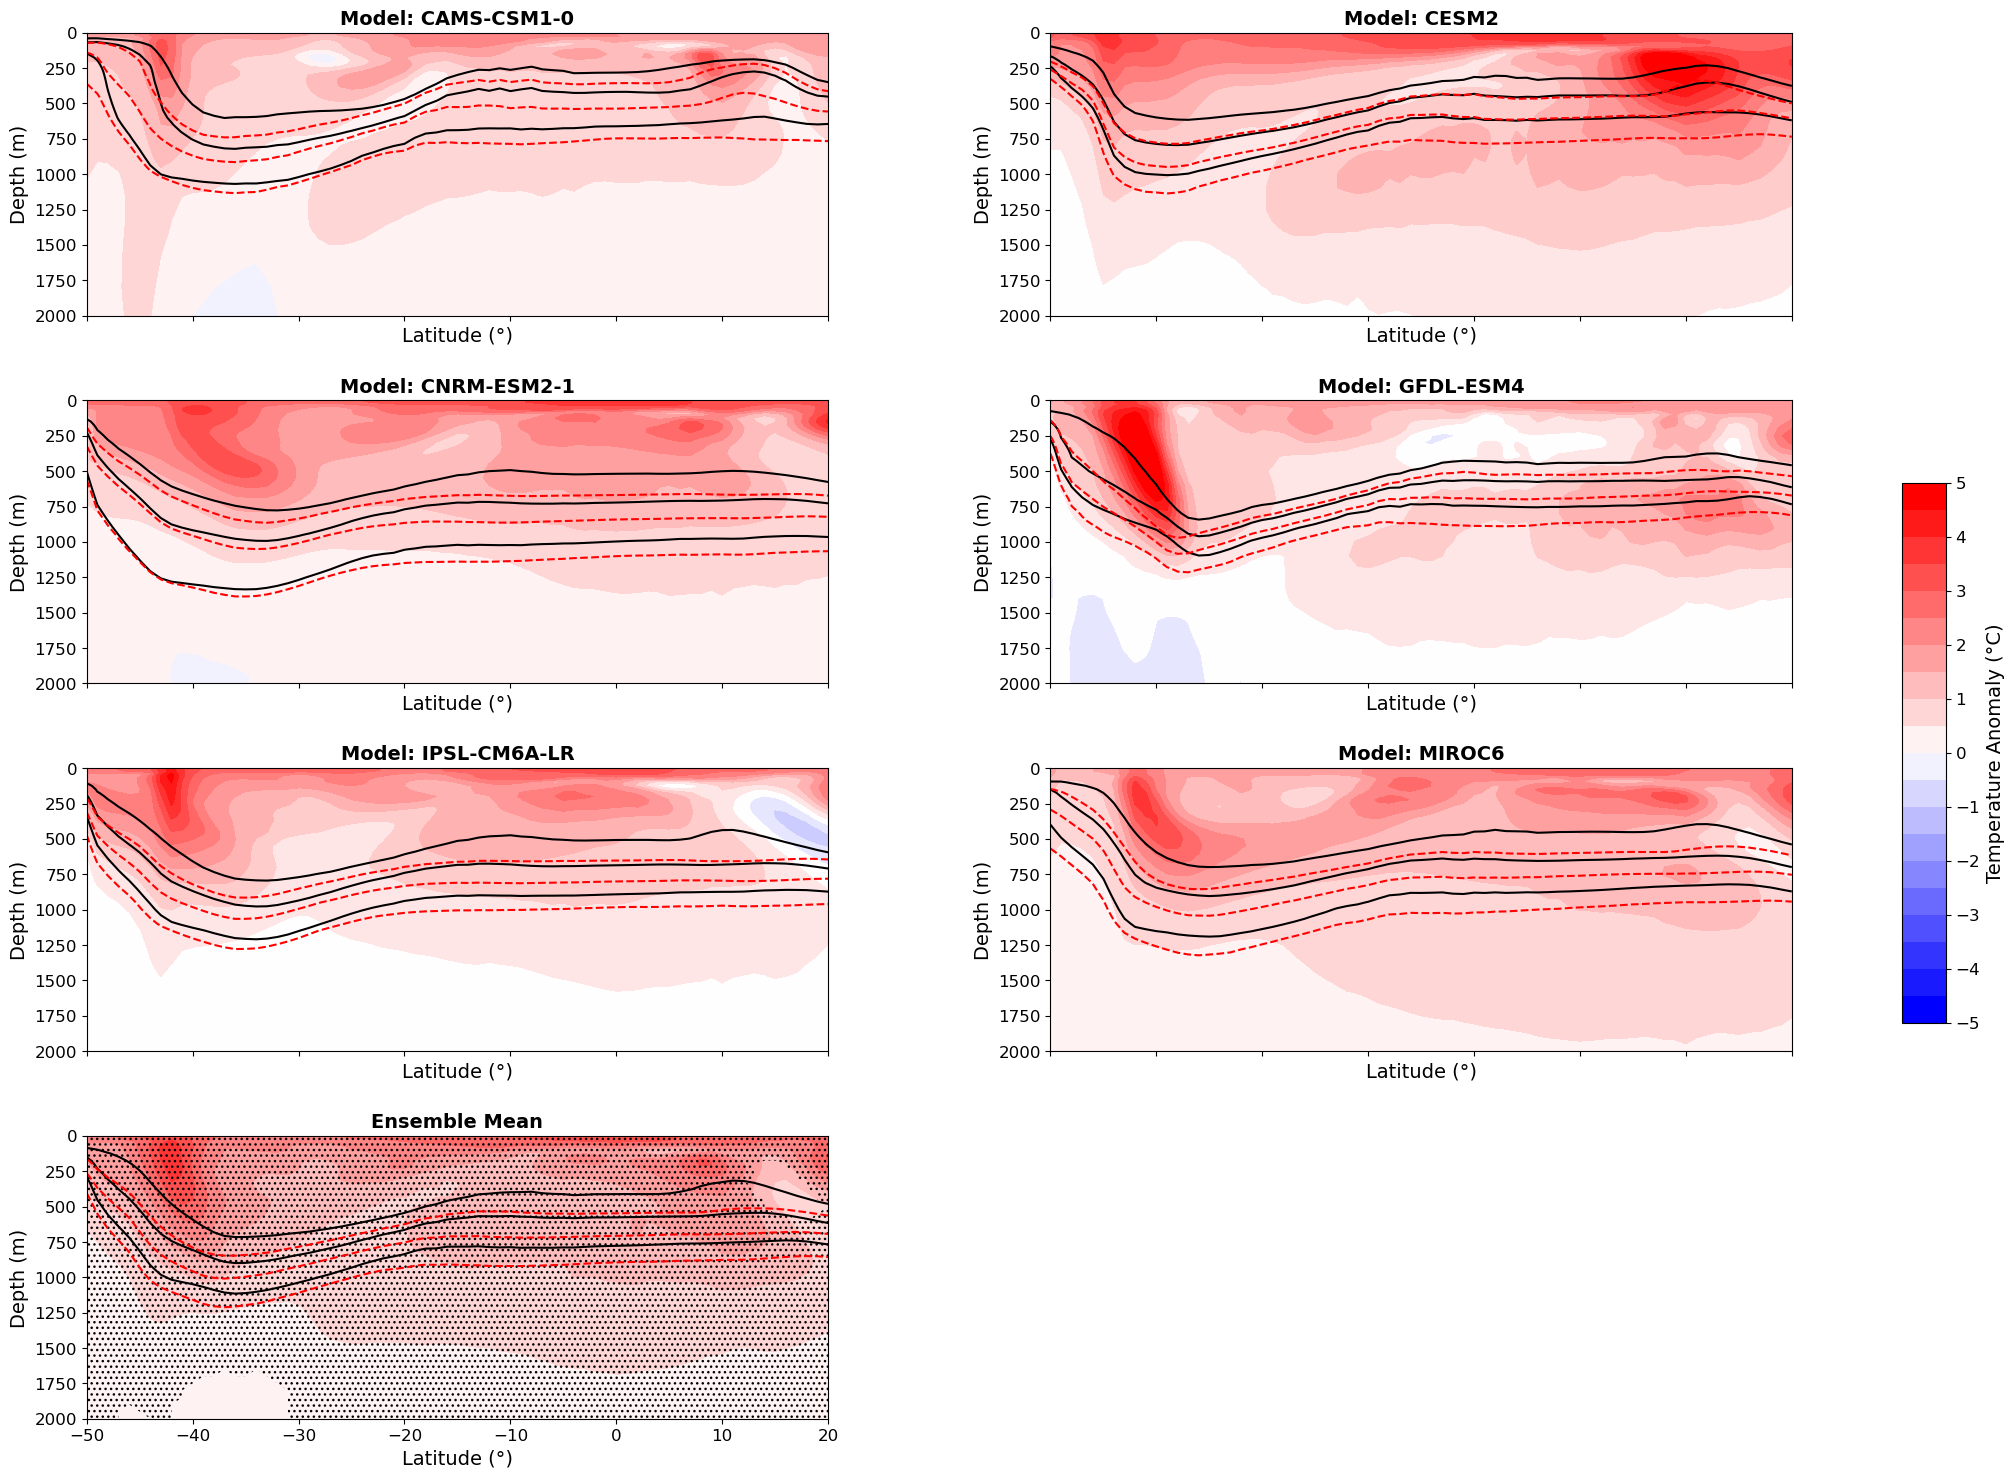

In [ ]:
import os
import glob
import xarray as xr
import gsw
import matplotlib.pyplot as plt
import numpy as np # Added
import matplotlib.colors # Added

# Gets the current directory where the notebook is located
pasta_atual = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'Arquivos')

# Uses the glob library to get all NetCDF files in the folder
arquivos = glob.glob(os.path.join(pasta_atual, '*.nc'))

# Sorts files based on model name
arquivos = sorted(arquivos, key=lambda x: os.path.basename(x).split(".")[2])

# Dictionary to store historical data
historical_data = {}

# Levels plot
c_levels = np.arange(-5, 5.01, 0.5)

### CHANGE 1: Add TwoSlopeNorm to center white at 0 ###
# (Logic from your script 2, but with values from -5 to 5 from script 1)
norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5)
### END OF CHANGE 1 ###


### CHANGE 2: Define sigma levels to plot ###
# Your script 1 had an undefined 'levels[model]' variable.
# Let's use a fixed list, as in your script 2.
# Adjust this list as needed.
sigma_levels_to_plot = [26.5, 27.0, 27.2] # Example
### END OF CHANGE 2 ###


# Loop through files for historical data
for arquivo in arquivos:
    if "historical" in arquivo:
        # Opens the dataset
        ds = xr.open_dataset(arquivo)

        # Gets model name from file name
        modelo = os.path.basename(arquivo).split(".")[2]

        # Calculates zonal mean for the historical period
        historical_data[modelo] = ds.sel(time=slice("1980", "2014")).mean(dim="time")

        # Closes the dataset
        ds.close()

### CHANGE 3: Increase the number of rows for the ensemble ###
# Initializes a figure with subplots (4 rows, 2 columns)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(22, 18), sharex=True) # Increased from 3 to 4 and figsize
### END OF CHANGE 3 ###

i, j = 0, 0

### CHANGE 4: Lists to store datasets for the ensemble ###
diff_datasets = []
historical_datasets_for_ensemble = []
ssp_datasets_for_ensemble = []
### END OF CHANGE 4 ###

# Loop again to process ssp585 files
for arquivo in arquivos:
    if "ssp585" in arquivo:
        # Opens the dataset
        ds = xr.open_dataset(arquivo)

        # Gets model name from file name
        modelo = os.path.basename(arquivo).split(".")[2]

        # Checks for historical data
        if modelo not in historical_data:
            print(f"Warning: Historical data not found for {modelo}. Skipping.")
            ds.close()
            continue

        # Calculates zonal mean for the SSP585 period
        ssp585_data = ds.sel(time=slice("2080", "2100")).mean(dim="time")

        # Gets model historical data
        historical = historical_data[modelo]

        historical["sigma0"] = gsw.sigma0(historical["sa"], historical["thetao"])
        ssp585_data["sigma0"] = gsw.sigma0(ssp585_data["sa"], ssp585_data["thetao"])
        diff = ssp585_data - historical

        ### CHANGE 5: Add data to ensemble lists ###
        diff_datasets.append(diff)
        historical_datasets_for_ensemble.append(historical)
        ssp_datasets_for_ensemble.append(ssp585_data)
        ### END OF CHANGE 5 ###

        ax = axs[i, j]

        # Plots in the correct subplot axs[i]
        # 'norm=norm' added
        contour = diff.thetao.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                            vmin=-5, vmax=5, norm=norm) # norm added

        # Apply mask for sigma0 > 26.2
        masked1_sigma0 = historical.sigma0.where(historical.sigma0 > 26.2)
        masked2_sigma0 = ssp585_data.sigma0.where(ssp585_data.sigma0 > 26.2)

        ### CHANGE 6: Simplify contour line plotting (as in script 2) ###
        # Use xarray's .plot.contour instead of matplotlib's ax.contour

        masked1_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                    colors='black', linestyles="solid")

        masked2_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                    colors='red', linestyles="dashed")
        ### END OF CHANGE 6 ###

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        ax.set_title(f"Model: {modelo}")

        # Adding X and Y axis labels
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

        ds.close()

        #Axes
        j += 1
        if j > 1:
            j = 0
            i += 1

        # Stops the loop if 'i' exceeds the number of rows
        if i >= axs.shape[0]:
            print("Warning: More models than available axes. Stopping plotting loop.")
            break

### CHANGE 7: Entire block for Ensemble Mean calculation and plot (with T-Test) ###
if diff_datasets:
    # Checks if the current axis (i, j) is still within limits
    if i < axs.shape[0]:
        # Gets the last available axis (should be axs[i, j])
        ax = axs[i, j]

        # --- Calculate Ensemble Means ---

        # Concatenates all anomaly datasets into a single xarray
        all_models_diff = xr.concat(diff_datasets, dim="model", coords="minimal", compat='override')

        # 1. Anomaly Mean (Diff)
        ensemble_mean_diff = all_models_diff.mean(dim="model")

        # 2. Historical Mean (for contour lines)
        ensemble_hist = xr.concat(historical_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_hist["sigma0"] = gsw.sigma0(ensemble_hist["sa"], ensemble_hist["thetao"])

        # 3. SSP Mean (for contour lines)
        ensemble_ssp = xr.concat(ssp_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_ssp["sigma0"] = gsw.sigma0(ensemble_ssp["sa"], ensemble_ssp["thetao"])


        # --- STATISTICAL SIGNIFICANCE CALCULATION (T-TEST) ---
        n_models = len(diff_datasets)
        significance_mask = None

        if n_models > 1: # t-test requires at least 2 samples
            # Calculates standard deviation across the 'model' dimension
            ensemble_std = all_models_diff.std(dim="model")

            # Calculates t-statistic: t = (mean - 0) / (std / sqrt(n))
            # **Note the change to .thetao**
            with np.errstate(divide='ignore', invalid='ignore'):
                t_stat = (ensemble_mean_diff.thetao / (ensemble_std.thetao / np.sqrt(n_models))).fillna(0)

            # Degrees of freedom = n - 1
            df = n_models - 1

            # Calculate p-values (numpy array)
            p_values_np = stats.t.sf(np.abs(t_stat.values), df=df) * 2

            # Convert p_values back to xarray.DataArray with coordinates
            p_values_da = xr.DataArray(p_values_np, coords=t_stat.coords, dims=t_stat.dims)

            # Create the mask (where p < 0.05, set to 1)
            significance_mask = xr.where(p_values_da < 0.05, 1, np.nan)
        # --- END OF SIGNIFICANCE CALCULATION ---


        # --- Plot Ensemble Mean Diff ---
        # **Note the change to .thetao and correct vmin/vmax**
        contour = ensemble_mean_diff.thetao.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                                          vmin=-5, vmax=5, norm=norm)

        # --- PLOT STIPPLING ---
        if significance_mask is not None:
            # We use contourf with 'hatches' to create stippling
            # We plot only where the mask is 1
            significance_mask.plot.contourf(
                ax=ax,
                levels=[0.5, 1.5],     # Levels to pick '1' values
                colors='none',         # We don't want color filling
                hatches=['...'],       # Defines the stippling pattern
                add_colorbar=False
            )
        # --- END OF STIPPLING ---


        # --- Plot Ensemble Sigma Lines ---
        ensemble_hist.sigma0.where(ensemble_hist.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='black', linestyles="solid")

        ensemble_ssp.sigma0.where(ensemble_ssp.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='red', linestyles="dashed")

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        ax.set_title("Ensemble Mean")
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')
### END OF CHANGE 7 ###

### CHANGE 8: Turn off remaining axes (if any) ###
# Calculates the "flat" index of the axis we just used for the ensemble
current_flat_index = i * axs.shape[1] + j
# Iterates and turns off all axes *after* the ensemble
for k in range(current_flat_index + 1, len(axs.flat)):
    axs.flat[k].axis('off')
### END OF CHANGE 8 ###


# Adds colorbar manually to subplot axs[i]
cbar_ax = fig.add_axes([0.95, 0.33, 0.02, 0.3])
cbar = plt.colorbar(contour, cax=cbar_ax, orientation='vertical', extendrect=True, shrink=0.1)
cbar.set_ticks(np.arange(-5, 5.1, 1)) # Correct ticks for temperature
cbar.set_label('Temperature Anomaly (°C)', size=14) # Correct label
cbar.ax.tick_params(labelsize=12)

# Defines title size, axes, etc.
# Modified to iterate only over plotted axes
for k in range(current_flat_index + 1):
    ax = axs.flat[k]
    ax.title.set_fontsize(14)
    ax.title.set_weight('bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

#Spacing between rows
plt.subplots_adjust(hspace=0.3, wspace=0.3) # wspace added

# Create 'Figuras' folder if it doesn't exist
os.makedirs('Figuras', exist_ok=True)

#Saves the figure
plt.savefig("Figuras_Estatistica/Anomalias_Modelos_Temperatura_SSP585_Ensemble.png", bbox_inches='tight', dpi=600)

# Displays the figure
plt.show()

### Temperature 370

C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gabri\miniconda3\envs\pygmt\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dty

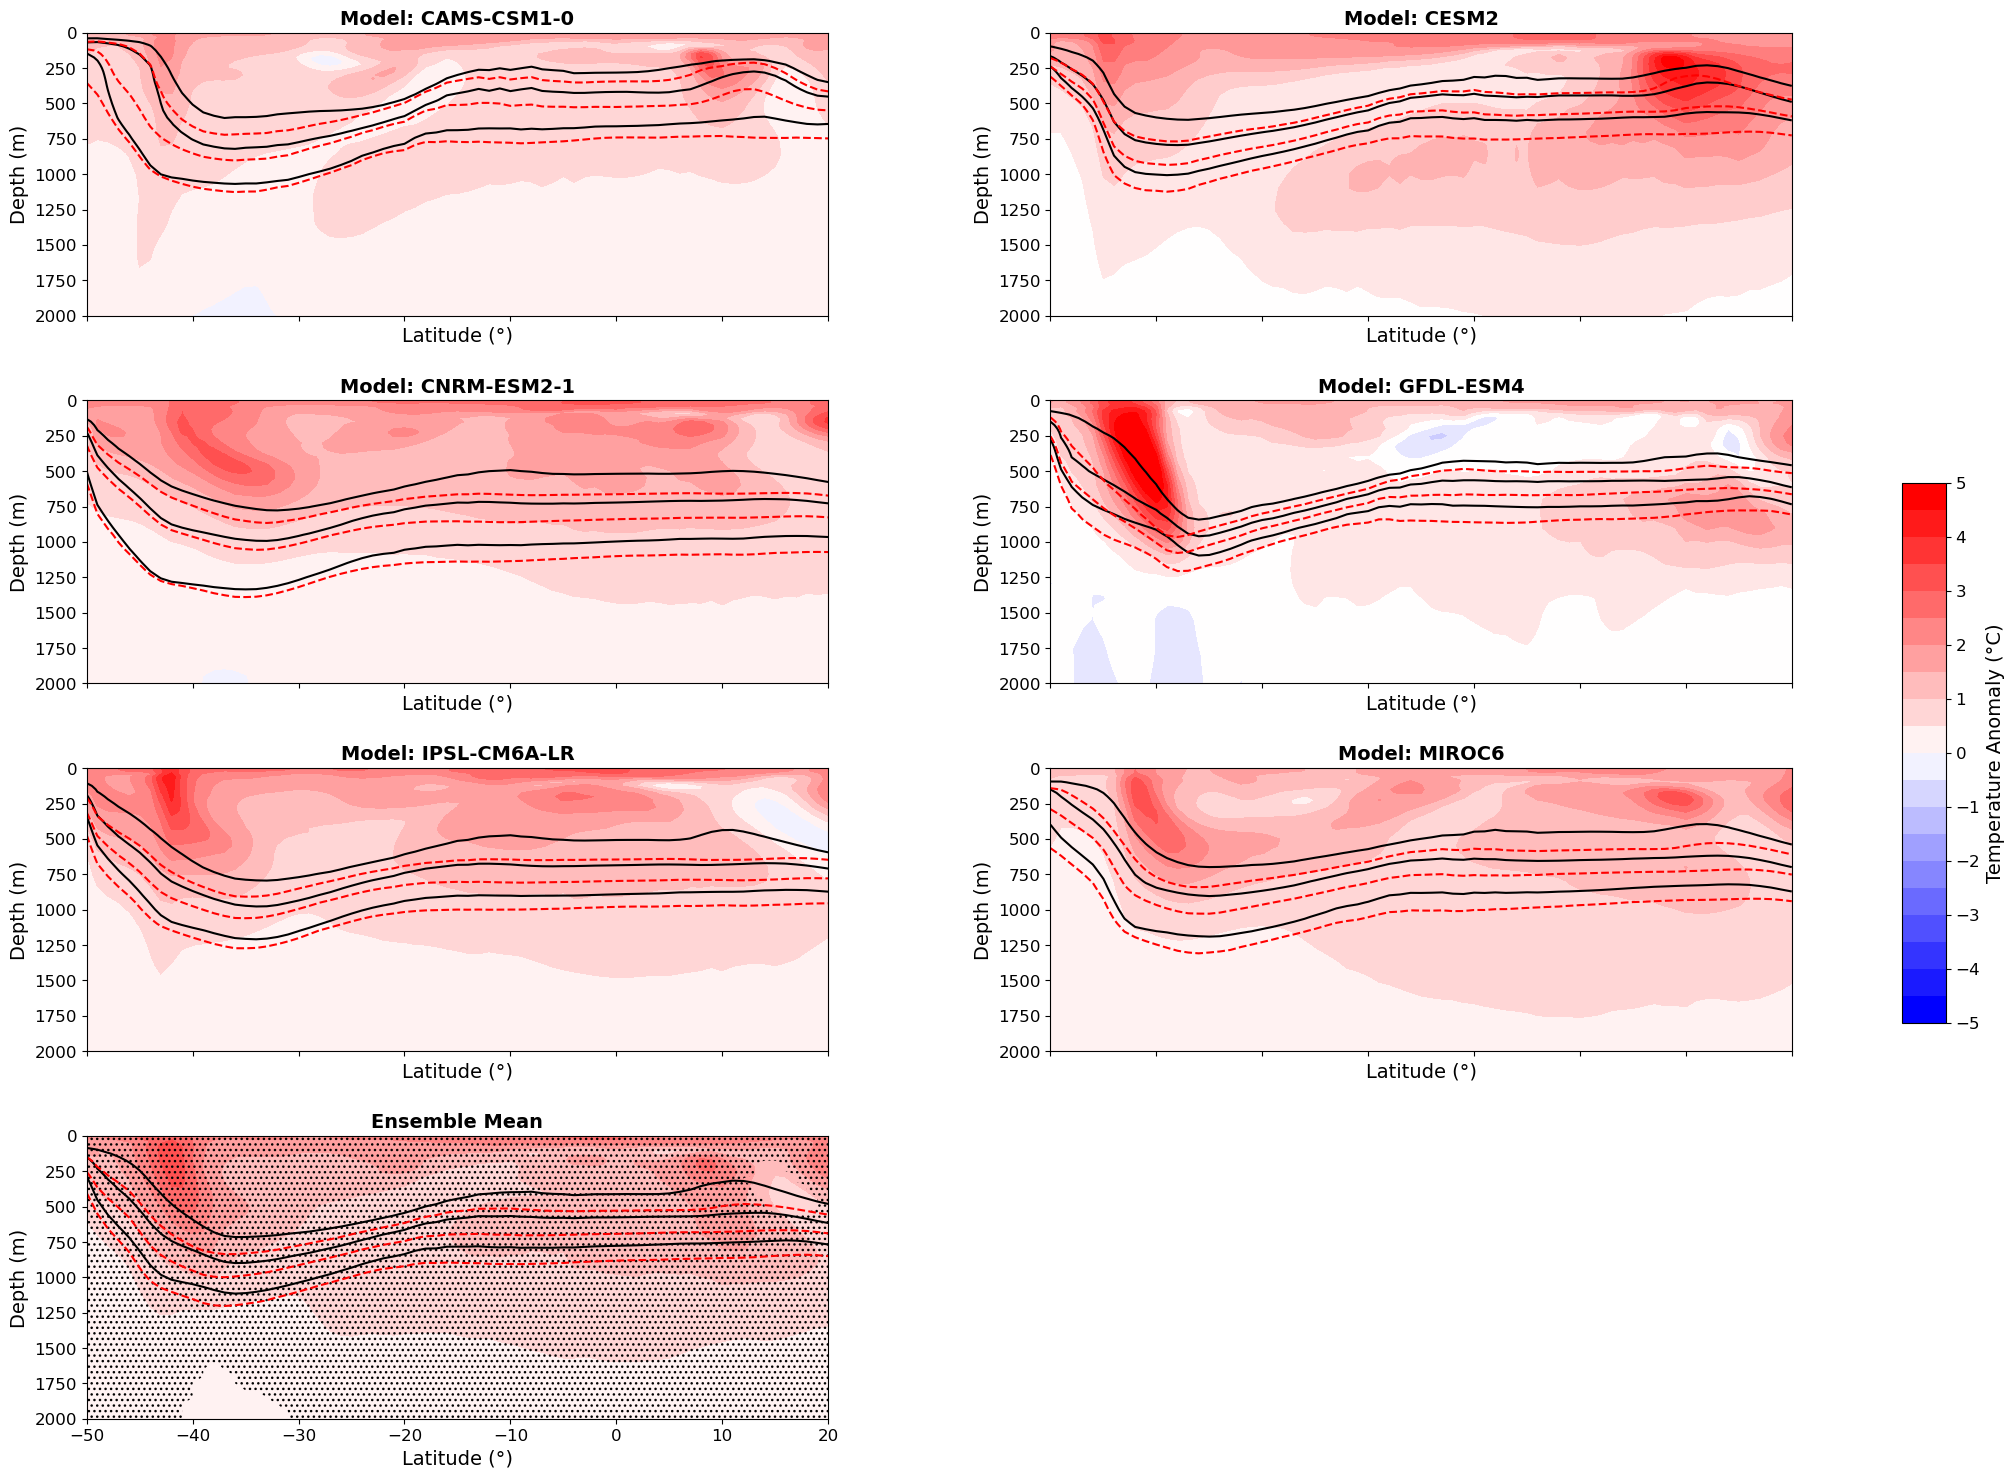

In [ ]:
import os
import glob
import xarray as xr
import gsw
import matplotlib.pyplot as plt
import numpy as np # Added
import matplotlib.colors # Added

# Gets the current directory where the notebook is located
pasta_atual = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'Arquivos')

# Uses the glob library to get all NetCDF files in the folder
arquivos = glob.glob(os.path.join(pasta_atual, '*.nc'))

# Sorts files based on model name
arquivos = sorted(arquivos, key=lambda x: os.path.basename(x).split(".")[2])

# Dictionary to store historical data
historical_data = {}

# Levels plot
c_levels = np.arange(-5, 5.01, 0.5)

### CHANGE 1: Add TwoSlopeNorm to center white at 0 ###
# (Logic from your script 2, but with values from -5 to 5 from script 1)
norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5)
### END OF CHANGE 1 ###


### CHANGE 2: Define sigma levels to plot ###
# Your script 1 had an undefined 'levels[model]' variable.
# Let's use a fixed list, as in your script 2.
# Adjust this list as needed.
sigma_levels_to_plot = [26.5, 27.0, 27.2] # Example
### END OF CHANGE 2 ###


# Loop through files for historical data
for arquivo in arquivos:
    if "historical" in arquivo:
        # Opens the dataset
        ds = xr.open_dataset(arquivo)

        # Gets model name from file name
        modelo = os.path.basename(arquivo).split(".")[2]

        # Calculates zonal mean for the historical period
        historical_data[modelo] = ds.sel(time=slice("1980", "2014")).mean(dim="time")

        # Closes the dataset
        ds.close()

### CHANGE 3: Increase the number of rows for the ensemble ###
# Initializes a figure with subplots (4 rows, 2 columns)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(22, 18), sharex=True) # Increased from 3 to 4 and figsize
### END OF CHANGE 3 ###

i, j = 0, 0

### CHANGE 4: Lists to store datasets for the ensemble ###
diff_datasets = []
historical_datasets_for_ensemble = []
ssp_datasets_for_ensemble = []
### END OF CHANGE 4 ###

# Loop again to process ssp585 files
for arquivo in arquivos:
    if "ssp370" in arquivo:
        # Opens the dataset
        ds = xr.open_dataset(arquivo)

        # Gets model name from file name
        modelo = os.path.basename(arquivo).split(".")[2]

        # Checks for historical data
        if modelo not in historical_data:
            print(f"Warning: Historical data not found for {modelo}. Skipping.")
            ds.close()
            continue

        # Calculates zonal mean for the SSP585 period
        ssp585_data = ds.sel(time=slice("2080", "2100")).mean(dim="time")

        # Gets model historical data
        historical = historical_data[modelo]

        historical["sigma0"] = gsw.sigma0(historical["sa"], historical["thetao"])
        ssp585_data["sigma0"] = gsw.sigma0(ssp585_data["sa"], ssp585_data["thetao"])
        diff = ssp585_data - historical

        ### CHANGE 5: Add data to ensemble lists ###
        diff_datasets.append(diff)
        historical_datasets_for_ensemble.append(historical)
        ssp_datasets_for_ensemble.append(ssp585_data)
        ### END OF CHANGE 5 ###

        ax = axs[i, j]

        # Plots in the correct subplot axs[i]
        # 'norm=norm' added
        contour = diff.thetao.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                            vmin=-5, vmax=5, norm=norm) # norm added

        # Apply mask for sigma0 > 26.2
        masked1_sigma0 = historical.sigma0.where(historical.sigma0 > 26.2)
        masked2_sigma0 = ssp585_data.sigma0.where(ssp585_data.sigma0 > 26.2)

        ### CHANGE 6: Simplify contour line plotting (as in script 2) ###
        # Use xarray's .plot.contour instead of matplotlib's ax.contour

        masked1_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                    colors='black', linestyles="solid")

        masked2_sigma0.plot.contour(ax=ax, levels=levels[modelo],
                                    colors='red', linestyles="dashed")
        ### END OF CHANGE 6 ###

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        ax.set_title(f"Model: {modelo}")

        # Adding X and Y axis labels
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')

        ds.close()

        #Axes
        j += 1
        if j > 1:
            j = 0
            i += 1

        # Stops the loop if 'i' exceeds the number of rows
        if i >= axs.shape[0]:
            print("Warning: More models than available axes. Stopping plotting loop.")
            break

### CHANGE 7: Entire block for Ensemble Mean calculation and plot (with T-Test) ###
if diff_datasets:
    # Checks if the current axis (i, j) is still within limits
    if i < axs.shape[0]:
        # Gets the last available axis (should be axs[i, j])
        ax = axs[i, j]

        # --- Calculate Ensemble Means ---

        # Concatenates all anomaly datasets into a single xarray
        all_models_diff = xr.concat(diff_datasets, dim="model", coords="minimal", compat='override')

        # 1. Anomaly Mean (Diff)
        ensemble_mean_diff = all_models_diff.mean(dim="model")

        # 2. Historical Mean (for contour lines)
        ensemble_hist = xr.concat(historical_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_hist["sigma0"] = gsw.sigma0(ensemble_hist["sa"], ensemble_hist["thetao"])

        # 3. SSP Mean (for contour lines)
        ensemble_ssp = xr.concat(ssp_datasets_for_ensemble, dim="model", coords="minimal", compat='override').mean(dim="model")
        ensemble_ssp["sigma0"] = gsw.sigma0(ensemble_ssp["sa"], ensemble_ssp["thetao"])


        # --- STATISTICAL SIGNIFICANCE CALCULATION (T-TEST) ---
        n_models = len(diff_datasets)
        significance_mask = None

        if n_models > 1: # t-test requires at least 2 samples
            # Calculates standard deviation across the 'model' dimension
            ensemble_std = all_models_diff.std(dim="model")

            # Calculates t-statistic: t = (mean - 0) / (std / sqrt(n))
            # **Note the change to .thetao**
            with np.errstate(divide='ignore', invalid='ignore'):
                t_stat = (ensemble_mean_diff.thetao / (ensemble_std.thetao / np.sqrt(n_models))).fillna(0)

            # Degrees of freedom = n - 1
            df = n_models - 1

            # Calculate p-values (numpy array)
            p_values_np = stats.t.sf(np.abs(t_stat.values), df=df) * 2

            # Convert p_values back to xarray.DataArray with coordinates
            p_values_da = xr.DataArray(p_values_np, coords=t_stat.coords, dims=t_stat.dims)

            # Create the mask (where p < 0.05, set to 1)
            significance_mask = xr.where(p_values_da < 0.05, 1, np.nan)
        # --- END OF SIGNIFICANCE CALCULATION ---


        # --- Plot Ensemble Mean Diff ---
        # **Note the change to .thetao and correct vmin/vmax**
        contour = ensemble_mean_diff.thetao.plot.contourf(ax=ax, x="lat", levels=c_levels, cmap="bwr", add_colorbar=False,
                                                          vmin=-5, vmax=5, norm=norm)

        # --- PLOT STIPPLING ---
        if significance_mask is not None:
            # We use contourf with 'hatches' to create stippling
            # We plot only where the mask is 1
            significance_mask.plot.contourf(
                ax=ax,
                levels=[0.5, 1.5],     # Levels to pick '1' values
                colors='none',         # We don't want color filling
                hatches=['...'],       # Defines the stippling pattern
                add_colorbar=False
            )
        # --- END OF STIPPLING ---


        # --- Plot Ensemble Sigma Lines ---
        ensemble_hist.sigma0.where(ensemble_hist.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='black', linestyles="solid")

        ensemble_ssp.sigma0.where(ensemble_ssp.sigma0 > 26.2).plot.contour(
            ax=ax, levels=ensemble_levels, colors='red', linestyles="dashed")

        ax.set_ylim(0, 2000)
        ax.invert_yaxis()
        ax.set_title("Ensemble Mean")
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Depth (m)')
### END OF CHANGE 7 ###

### CHANGE 8: Turn off remaining axes (if any) ###
# Calculates the "flat" index of the axis we just used for the ensemble
current_flat_index = i * axs.shape[1] + j
# Iterates and turns off all axes *after* the ensemble
for k in range(current_flat_index + 1, len(axs.flat)):
    axs.flat[k].axis('off')
### END OF CHANGE 8 ###


# Adds colorbar manually to subplot axs[i]
cbar_ax = fig.add_axes([0.95, 0.33, 0.02, 0.3])
cbar = plt.colorbar(contour, cax=cbar_ax, orientation='vertical', extendrect=True, shrink=0.1)
cbar.set_ticks(np.arange(-5, 5.1, 1)) # Correct ticks for temperature
cbar.set_label('Temperature Anomaly (°C)', size=14) # Correct label
cbar.ax.tick_params(labelsize=12)

# Defines title size, axes, etc.
# Modified to iterate only over plotted axes
for k in range(current_flat_index + 1):
    ax = axs.flat[k]
    ax.title.set_fontsize(14)
    ax.title.set_weight('bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

#Spacing between rows
plt.subplots_adjust(hspace=0.3, wspace=0.3) # wspace added

# Create 'Figuras' folder if it doesn't exist
os.makedirs('Figuras', exist_ok=True)

#Saves the figure
plt.savefig("Figuras_Estatistica/Anomalias_Modelos_Temperatura_SSP370_Ensemble.png", bbox_inches='tight', dpi=600)

# Displays the figure
plt.show()